In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Homography

Let $(x^{'}, y^{'})$ be a point in the first image and $(x, y)$ be the coordinates of the same physical point in the second image.

Then, the Homography $H$ relates them in the following way

\begin{bmatrix} x^{'} \\ y^{'} \\ 1 \end{bmatrix} = \mathbf{H} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} = \begin{bmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}


The homography matrix is a 3x3 matrix but with 8 DoF (degrees of freedom) as it is estimated up to a scale

$h_{11}^2 + h_{12}^2 + h_{13}^2 + h_{21}^2 + h_{22}^2 + h_{23}^2 + h_{31}^2 + h_{32}^2 + h_{33}^2 = 1$

The following examples show different kinds of transformation but all relate a transformation between two planes.

1. A planar surface and the image plane

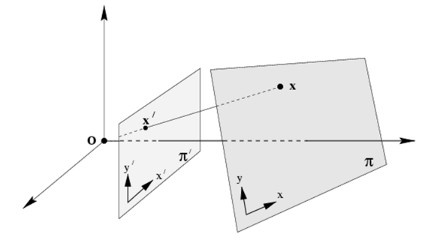

2. A planar surface viewed by two camera positions

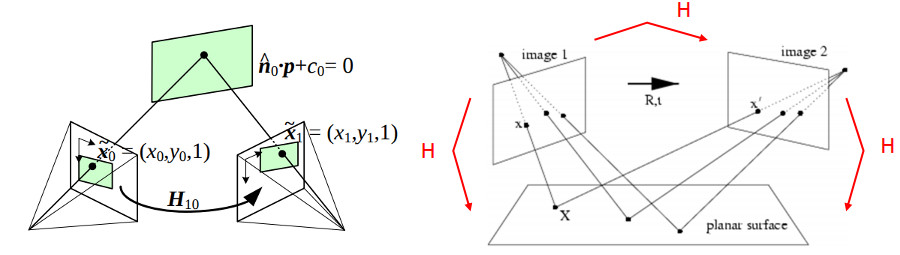

3. A rotating camera around its axis of projection, equivalent to consider that the points are on a plane at infinity

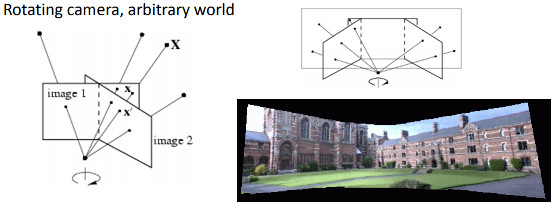

If we know 4 or more corresponding points in the two images, we can find the homography

**Find corresponding points automatically**

Identifying stable points of interest in an image can be done by looking for **key points or feature points**. There are several keypoint detectors implemented in OpenCV (e.g. SIFT, SURF, and ORB).

A feature point detector has two parts
1. Locator: This identifies points on the image that are stable under image transformations like translation (shift), scale (increase / decrease in size), and rotation. The locator finds the x, y coordinates of such points. The locator used by the ORB detector is called FAST.

2. Descriptor: The descriptor encodes the appearance of the point so that we can tell one feature point from the other. The descriptor evaluated at a feature point is simply an array of numbers. Ideally, the same physical point in two images should have the same descriptor.

### Image Registration and Alignment

In a typical image alignment problem we have two images of a scene, and they are related by a **motion model**

1. Translation: The first image can be shifted ( translated ) by (x , y) to obtain the second image.
2. Euclidean: The first image is a rotated and shifted version of the second image. So there are three parameters — x, y and angle.
3. Affine: An affine transform is a combination of rotation, translation ( shift ), scale, and shear. This transform has six parameters.
4. Homography: A homography transform on the other hand can account for some 3D effects ( but not all ). This transform has 8 parameters.

Image alignment and registration is the process of:
1. Accepting two input images that contain the same object but at slightly different viewing angles
2. Automatically computing the motion model used to align the images (featured-based keypoint correspondences, similarity measures, or deep neural networks)
3. Taking that warp matrix and applying a perspective warp to align the images together

There are a number of image alignment and registration algorithms:

1. Feature-based and include keypoint detectors (DoG, Harris, GFFT, etc.), local invariant descriptors (SIFT, SURF, ORB, etc.), and keypoint matching (RANSAC and its variants).
2. Medical applications often use similarity measures for image registration, typically cross-correlation, sum of squared intensity differences, and mutual information.
3. Deep learning can even be used for image alignment by automatically learning the homography transform.

### Implementation

**1. Document Alignment (Feature Matching)**

- Feature-based methods start with detecting keypoints in our two input images. Keypoints are meant to identify salient regions of an input image.
- For each keypoint, we extract local invariant descriptors, which quantify the region surrounding each keypoint in the input image.
- We apply algorithms such as **RANSAC** to match our keypoints and determine their correspondences

In [4]:
input_img = cv2.imread("./images/scanned-form.jpg", cv2.IMREAD_UNCHANGED)

In [3]:
template_img = cv2.imread("./images/form.jpg", cv2.IMREAD_UNCHANGED)

In [17]:
def align_document(input_img, template_img, max_features=500, top_features_percent=20, debug=True):
    input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    template_img_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
    
    height, width = template_img_gray.shape

    # ORB algorithm to detect keypoints and extract binary local invariant features
    orb = cv2.ORB_create(max_features)

    (keypoints_input, descriptors_input) = orb.detectAndCompute(input_img_gray, None)
    (keypoints_template, descriptors_template) = orb.detectAndCompute(template_img_gray, None)
    
    descriptor_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    descriptor_matches = sorted(descriptor_matcher.match(descriptors_input, descriptors_template), key=lambda m: m.distance)
    
    features_count = int(len(descriptor_matches) * (top_features_percent / 100))
    selected_matches = descriptor_matches[:features_count]

    if debug:
        matched_img = cv2.drawMatches(input_img, keypoints_input, template_img, keypoints_template, selected_matches, None)
        plt.imshow(matched_img)
        plt.show()

    # Compute homography matrix using the keypoints and RANSAC algorithm
    points_input = np.zeros((len(selected_matches), 2), dtype="float")
    points_template = np.zeros((len(selected_matches), 2), dtype="float")
    
    for (idx, match) in enumerate(selected_matches):
        points_input[idx] = keypoints_input[match.queryIdx].pt
        points_template[idx] = keypoints_template[match.trainIdx].pt

    (H, mask) = cv2.findHomography(points_input, points_template, method=cv2.RANSAC)
	
    return cv2.warpPerspective(input_img, H, (width, height))

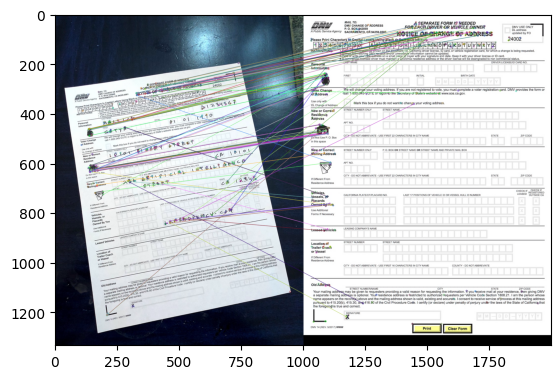

In [18]:
img_aligned = align_document(input_img, template_img, debug=True)

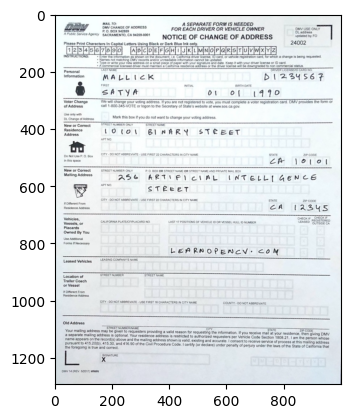

In [19]:
plt.imshow(img_aligned)
plt.show()

**2. Automating Prokudin-Gorskii Photo Collection Colorization**

- Each photograph is in fact a montage of three copies of the same image stacked one above the other.
- Each copy within the montage represents one of the three channels of the RGB color spectrum.
- The aim of this study was to use image processing techniques to autonomously and efficiently split the image into its three parts, align and stack them correctly to produce a colour image, and apply similarity measure called **Enhanced Correlation Coefficient (ECC)** to complete this task

In [22]:
img = cv2.imread("./images/lady.jpg", cv2.IMREAD_UNCHANGED)

Calculate the image gradients using Sobel operator

In [23]:
def get_gradient(img) :
    g_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    g_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
 
    return cv2.addWeighted(np.absolute(g_x), 0.5, np.absolute(g_y), 0.5, 0)

In [24]:
def auto_colorization(img, warp_mode=cv2.MOTION_HOMOGRAPHY, n_iterations=5000, termination_eps=1e-10, debug=True):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if debug:
        plt.imshow(img_gray, cmap="gray")
        plt.show()

    height, width = img_gray.shape

    # Calculate the height for each color channel (B, G, R)
    channel_height = height // 3

    # Align and stack color image
    img_color = np.zeros((channel_height, width, 3), dtype=np.uint8)
    for i in range(3):
        img_color[:, :, i] = img_gray[i * channel_height:(i + 1) * channel_height, :]

    
    img_aligned = np.zeros((channel_height, width, 3), dtype=np.uint8)

    # Copy the red channel. The blue and green channel will be aligned to the red channel. 
    img_aligned[:, :, 2] = img_color[:, :, 2]

    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, n_iterations, termination_eps)

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else:
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    for i in range(2):
        (cc, warp_matrix) = cv2.findTransformECC(get_gradient(img_color[:,:,2]), get_gradient(img_color[:,:,i]), warp_matrix, warp_mode, criteria)

        if warp_mode == cv2.MOTION_HOMOGRAPHY :
            img_aligned[:,:,i] = cv2.warpPerspective(img_color[:,:,i], warp_matrix, (width, channel_height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        else:
            img_aligned[:,:,i] = cv2.warpAffine(img_color[:,:,i], warp_matrix, (width, channel_height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

    
    return cv2.cvtColor(img_aligned, cv2.COLOR_BGR2RGB)

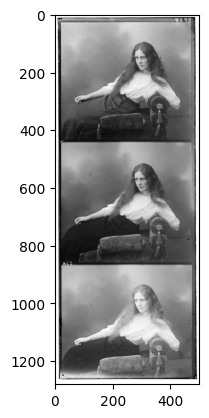

In [25]:
img_aligned = auto_colorization(img, debug=True)

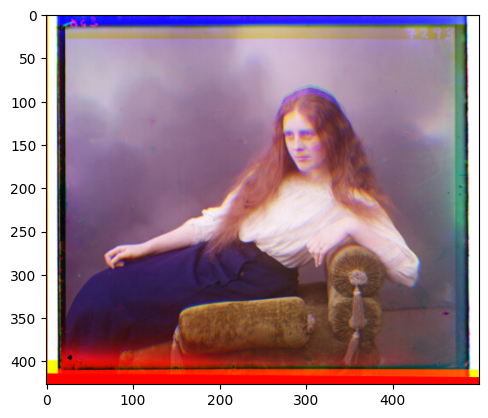

In [26]:
plt.imshow(img_aligned)
plt.show()

### References

- https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html
- https://learnopencv.com/image-alignment-ecc-in-opencv-c-python
- https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/
- https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/